In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.insert(0, '../..')

%matplotlib inline
sns.set()

In [2]:
from collections import namedtuple

Y = namedtuple('Y', ['mu', 'std', 'c_l', 'c_u'])
Keys = ['loss', 'norm', 'mse', 'mae', 'smape', 'rmse', 'mape']

In [3]:
import glob

In [4]:
dataset = 'sm1_2010.csv'

In [5]:
no_kaf = glob.glob(f'../../logs/{dataset}/darnn_0_0/*/*')
kaf_time = glob.glob(f'../../logs/{dataset}/darnn_0_1/*/*')
kaf_input = glob.glob(f'../../logs/{dataset}/darnn_1_0/*/*')
kaf_dual = glob.glob(f'../../logs/{dataset}/darnn_1_1/*/*')
seq2seq = glob.glob(f'../../logs/{dataset}/seq2seq_1_1/*/*')

In [6]:
no_kaf = glob.glob(f'../../logs/{dataset}/darnn_0_0/*/*')[0]
kaf_time = glob.glob(f'../../logs/{dataset}/darnn_0_1/*/*')[0]
kaf_input = glob.glob(f'../../logs/{dataset}/darnn_1_0/*/*')[0]
kaf_dual = glob.glob(f'../../logs/{dataset}/darnn_1_1/*/*')[0]
seq2seq = glob.glob(f'../../logs/{dataset}/seq2seq_1_1/*/*')[0]

In [7]:
def get_ci(x, z=1.96):
    if x.ndim == 2:
        n = x.shape[1]
        mu = x.mean(axis=1)
        std = x.std(axis=1)
    else:
        n = x.shape[0]
        mu = x.mean()
        std = x.std()
        
    c_l, c_u = (mu - z * std/np.sqrt(n), mu + z * std/np.sqrt(n))
    return mu, std, c_l, c_u

In [8]:
def get_train_results(path, key='mae', z=1.96):
    return Y(*get_ci(pd.concat([pd.read_csv(x+'/train/results.csv')[key] for x in path], axis=1), z=z))

In [9]:
df_no_kaf = pd.read_csv(no_kaf + '/train/results.csv')
df_kaf_time = pd.read_csv(kaf_time + '/train/results.csv')
df_kaf_input = pd.read_csv(kaf_input + '/train/results.csv')
df_kaf_dual = pd.read_csv(kaf_dual + '/train/results.csv')
df_seq2seq = pd.read_csv(seq2seq + '/train/results.csv')

In [10]:
def smooth(x,w=0.5):
    p = x[0]
    xs = []
    for d in x:
        p = p * w + (1-w) * d
        xs.append(p)
    return np.array(xs)

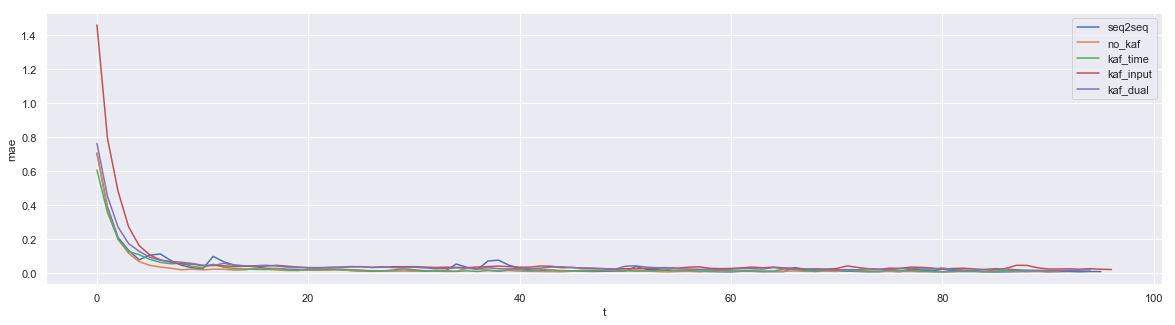

In [11]:
fig,ax = plt.subplots(1,1, figsize=(20,5))
ax.plot(smooth(df_seq2seq.loss.values))
ax.plot(smooth(df_no_kaf.loss.values))
ax.plot(smooth(df_kaf_time.loss.values))
ax.plot(smooth(df_kaf_input.loss.values))
ax.plot(smooth(df_kaf_dual.loss.values))
plt.ylabel('mae')
plt.xlabel('t')
plt.legend(['seq2seq','no_kaf','kaf_time','kaf_input', 'kaf_dual'])

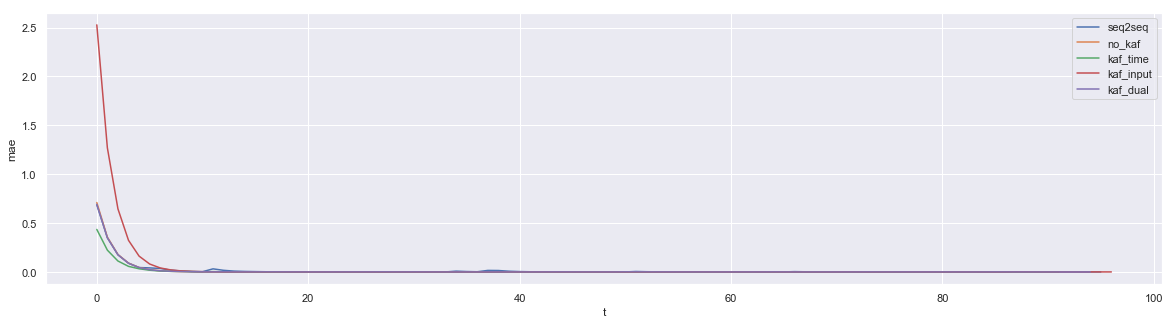

In [12]:
fig,ax = plt.subplots(1,1, figsize=(20,5))
ax.plot(smooth(df_seq2seq.mse.values))
ax.plot(smooth(df_no_kaf.mse.values))
ax.plot(smooth(df_kaf_time.mse.values))
ax.plot(smooth(df_kaf_input.mse.values))
ax.plot(smooth(df_kaf_dual.mse.values))
plt.ylabel('mae')
plt.xlabel('t')
plt.legend(['seq2seq','no_kaf','kaf_time','kaf_input', 'kaf_dual'])

In [13]:
df_no_kaf.insert(1, 'reg', value=np.zeros(len(df_no_kaf)))

In [14]:
# no reg
rows = ['seq2seq','no_kaf','kaf_time','kaf_input', 'kaf_dual']

table = pd.concat([df_seq2seq.mean(axis=0),
                   df_no_kaf.mean(axis=0), 
                   df_kaf_time.mean(axis=0), 
                   df_kaf_input.mean(axis=0), 
                   df_kaf_dual.mean(axis=0),
                  ], axis=1)
table.columns = rows

table.T

,loss,reg,norm,mse,mae,smape,rmse,mape
seq2seq,0.028390,0.001891,1.230757,0.009731,0.026499,0.051889,0.026499,15.402096
no_kaf,0.020724,0.000000,3.669931,0.008151,0.020724,0.036891,0.020724,8.311402
kaf_time,0.025245,0.002142,4.578365,0.005495,0.023103,0.039711,0.023103,8.971744
kaf_input,0.049150,0.015612,5.822568,0.026985,0.033538,0.046097,0.033538,10.097149
kaf_dual,0.039130,0.016478,3.365377,0.007868,0.022652,0.040582,0.022652,10.065119


In [15]:
table = pd.concat([
                    df_seq2seq.std(axis=0)/np.sqrt(len(df_seq2seq)),
                    df_no_kaf.std(axis=0)/np.sqrt(len(df_no_kaf)), 
                    df_kaf_time.std(axis=0)/np.sqrt(len(df_kaf_time)), 
                    df_kaf_input.std(axis=0)/np.sqrt(len(df_kaf_input)), 
                    df_kaf_dual.std(axis=0)/np.sqrt(len(df_kaf_dual)),
                  ], axis=1)
table.columns = rows

# +/- z * std/sqrt(N)
table.T

,loss,reg,norm,mse,mae,smape,rmse,mape
seq2seq,0.007720,0.000096,0.072853,0.007192,0.007694,0.015395,0.007694,4.664057
no_kaf,0.007608,0.000000,0.209785,0.007719,0.007608,0.014749,0.007608,1.184260
kaf_time,0.006645,0.000490,0.281518,0.004723,0.006320,0.014816,0.006320,1.231184
kaf_input,0.014859,0.000723,0.305410,0.026054,0.014502,0.017489,0.014502,1.522997
kaf_dual,0.007953,0.001222,0.207597,0.007285,0.007226,0.014440,0.007226,1.725564


In [16]:
table.index

Index(['loss', 'reg', 'norm', 'mse', 'mae', 'smape', 'rmse', 'mape'], dtype='object')

In [17]:
header = table.index.tolist()

In [18]:
df_no_kaf = pd.read_csv(no_kaf + '/test/results.csv', header=None)
df_no_kaf.insert(1, 'reg', value=np.zeros(len(df_no_kaf)))
df_no_kaf.columns = header

In [19]:
df_seq2seq = pd.read_csv(seq2seq+ '/test/results.csv', names=header)
df_kaf_time = pd.read_csv(kaf_time + '/test/results.csv', names=header)
df_kaf_input = pd.read_csv(kaf_input + '/test/results.csv', names=header)
df_kaf_dual = pd.read_csv(kaf_dual+ '/test/results.csv', names=header)

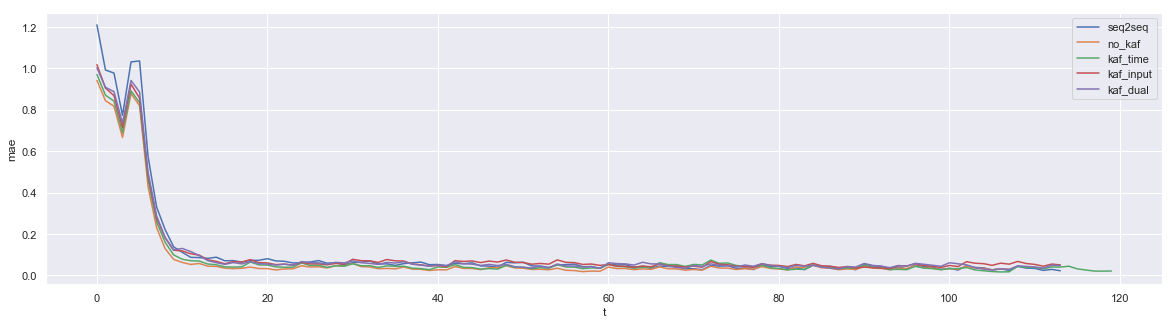

In [20]:
fig,ax = plt.subplots(1,1, figsize=(20,5))
ax.plot(smooth(df_seq2seq.loss.values))
ax.plot(smooth(df_no_kaf.loss.values))
ax.plot(smooth(df_kaf_time.loss.values))
ax.plot(smooth(df_kaf_input.loss.values))
ax.plot(smooth(df_kaf_dual.loss.values))
plt.ylabel('mae')
plt.xlabel('t')
plt.legend(['seq2seq','no_kaf','kaf_time','kaf_input', 'kaf_dual'])

In [21]:
table = pd.concat([
                    df_seq2seq.mean(axis=0),
                    df_no_kaf.mean(axis=0), 
                    df_kaf_time.mean(axis=0), 
                    df_kaf_input.mean(axis=0), 
                    df_kaf_dual.mean(axis=0),
                  ], axis=1)
table.columns = rows

In [22]:
# no reg
table.T

,loss,reg,norm,mse,mae,smape,rmse,mape
seq2seq,0.098353,0.002349,1.477276,0.091131,0.096004,0.139889,0.096004,26.477051
no_kaf,0.077261,0.000000,4.424213,0.061517,0.077261,0.114360,0.077261,13.174437
kaf_time,0.080244,0.002590,5.198434,0.056051,0.077654,0.111650,0.077654,14.842873
kaf_input,0.098073,0.016354,5.121215,0.060537,0.081719,0.119305,0.081719,16.509247
kaf_dual,0.095163,0.017400,3.566217,0.060261,0.077763,0.113835,0.077763,14.643843


In [23]:
table = pd.concat([
                    df_seq2seq.std(axis=0)/np.sqrt(len(df_seq2seq)),
                    df_no_kaf.std(axis=0)/np.sqrt(len(df_no_kaf)), 
                    df_kaf_time.std(axis=0)/np.sqrt(len(df_kaf_time)), 
                    df_kaf_input.std(axis=0)/np.sqrt(len(df_kaf_input)), 
                    df_kaf_dual.std(axis=0)/np.sqrt(len(df_kaf_dual)),
                  ], axis=1)
table.columns = rows

# +/- z * std/sqrt(N)
table.T

,loss,reg,norm,mse,mae,smape,rmse,mape
seq2seq,0.020223,0.000087,0.055616,0.032235,0.020179,0.028025,0.020179,4.046459
no_kaf,0.017626,0.000000,0.177150,0.023605,0.017626,0.029946,0.017626,2.120568
kaf_time,0.016176,0.000532,0.200288,0.020789,0.015711,0.026647,0.015711,2.020973
kaf_input,0.017292,0.000807,0.225034,0.022335,0.016656,0.028178,0.016656,2.291443
kaf_dual,0.017750,0.001370,0.152912,0.022098,0.016581,0.028073,0.016581,2.050601


In [24]:
def last_path(base_path):
    paths = glob.glob(base_path + '/report/*.csv')
    idxs = list(map(lambda x: int(x.split('/')[-1].split('_')[0]), paths))
    idx = max(idxs)
    paths
    return base_path + '/report/' + ''.join([str(idx), '_', 'report.csv'])

In [25]:
df_no_kaf = pd.read_csv(last_path(no_kaf), index_col=0)
# df_dense = pd.read_csv(last_path(dense), index_col=0)
df_seq2seq = pd.read_csv(last_path(seq2seq), index_col=0)
df_kaf_time = pd.read_csv(last_path(kaf_time), index_col=0)
df_kaf_input = pd.read_csv(last_path(kaf_input), index_col=0)
df_kaf_dual = pd.read_csv(last_path(kaf_dual), index_col=0)

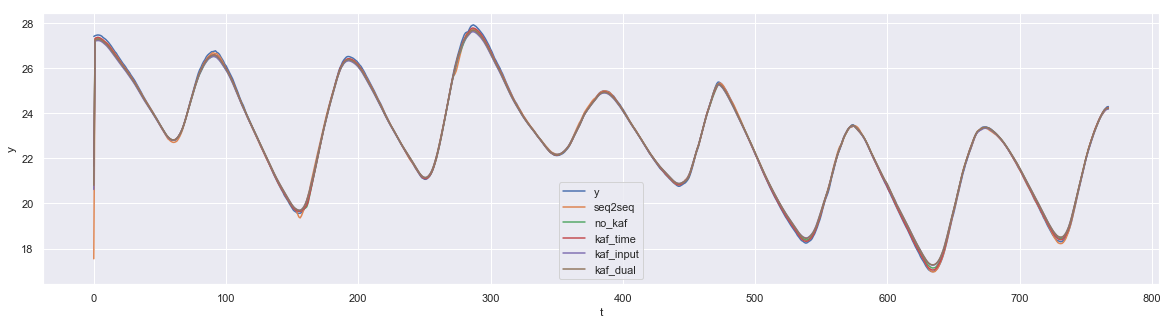

In [26]:
fig,ax = plt.subplots(1,1, figsize=(20,5))
ax.plot(df_no_kaf.y.values)
ax.plot(df_seq2seq.y_hat.values)
ax.plot(df_no_kaf.y_hat.values)
# ax.plot(df_dense.y_hat.values)
ax.plot(df_kaf_time.y_hat.values)
ax.plot(df_kaf_input.y_hat.values)
ax.plot(df_kaf_dual.y_hat.values)
plt.ylabel('y')
plt.xlabel('t')
plt.legend(['y',
            'seq2seq','no_kaf','kaf_time','kaf_input', 'kaf_dual'])

In [27]:
from ntsa.utils.misc import regr_metrics

In [28]:
y = df_no_kaf.y.values
y_seq2seq = df_seq2seq.y_hat.values
y_no_kaf = df_no_kaf.y_hat.values
y_kaf_time = df_kaf_time.y_hat.values
y_kaf_input = df_kaf_input.y_hat.values
y_kaf_dual = df_kaf_dual.y_hat.values

In [29]:
metrics = [
list(regr_metrics(y, y_seq2seq).values()),
list(regr_metrics(y, y_no_kaf).values()),
list(regr_metrics(y, y_kaf_time).values()),
list(regr_metrics(y, y_kaf_input).values()),
list(regr_metrics(y, y_kaf_dual).values())
]

In [30]:
pd.DataFrame(np.array(metrics), index=['seq2seq','no_kaf',
                                       'time', 'input', 'dual'], columns=['mse', 'mae', 'smape', 'mape'])

,mse,mae,smape,mape
seq2seq,0.133493,0.075699,0.003338,0.350556
no_kaf,0.048397,0.085209,0.003725,0.376856
time,0.047580,0.061052,0.002653,0.269934
input,0.076887,0.113809,0.005070,0.513778
dual,0.069667,0.099424,0.004512,0.457153
